In [60]:
%load_ext autoreload
%autoreload 2
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.data import Dataset
import csv
from PIL import Image
import re
from torchsummary import summary

cudnn.benchmark = True
plt.ion()



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Dataset

In [61]:
class CustomDataset(Dataset):
    def __init__(self, path, transform=None):
        super().__init__()
        self.transform = transform
        self.main_dir = os.path.join(path)
        self.all_imgs = sorted(os.listdir(self.main_dir), key=lambda s: int(re.search(r'\d+', s).group()))
        
    def __len__(self):
        return len(self.all_imgs)
    
    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.all_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

Device

In [62]:
#apple
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
#windows
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

mps


Load Data

In [63]:

data_transforms =  transforms.Compose([
        transforms.Resize((512,512)),
        transforms.ToTensor(),
    ])
directory = os.getcwd()
data_dir = '/Users/nayansavaliya/Desktop/AnomalyDetection/data/transistor/train/good'
train_dataset = CustomDataset(data_dir,data_transforms)
test_dataset = CustomDataset('/Users/nayansavaliya/Desktop/AnomalyDetection/data/transistor/test/bent_lead',data_transforms)
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [0.8, 0.2])
train_dataloader =  torch.utils.data.DataLoader(train_dataset, batch_size=4,
                                             shuffle=False, num_workers=0)

val_dataloader =  torch.utils.data.DataLoader(val_dataset, batch_size=4,
                                             shuffle=False, num_workers=0)

test_dataloader =  torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                             shuffle=False, num_workers=0)

print(len(train_dataloader),len(val_dataloader),len(test_dataloader))

43 11 10


View Data

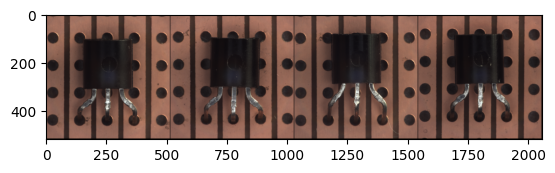

In [64]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of  data
inputs = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

Datasets & DataLoaders

In [65]:
image_datasets = {'train': train_dataset }
dataloaders = {'train': train_dataloader}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train']}


Encoder

In [66]:
class AutoEncoder(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=4, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(256),
            nn.Flatten(),
            nn.Linear(256*13*13, 3),#13*13  #29*29
        )    
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 256*13*13),
            nn.Unflatten(dim=1, unflattened_size=(256, 13, 13)),
            nn.ConvTranspose2d(256, 128, 4, 1, 0, bias=True),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=True),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=True),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 4, 2, 1, bias=True),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 4, 2, 1, bias=True),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 3, 4, 2, 1, bias=True),
            nn.ReLU(True)
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def encode(self, x):
        x = self.encoder(x)
        return x
    

In [67]:
testModel = AutoEncoder()
summary(testModel, (3, 512, 512),4)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [4, 8, 256, 256]             392
       BatchNorm2d-2           [4, 8, 256, 256]              16
              ReLU-3           [4, 8, 256, 256]               0
            Conv2d-4          [4, 16, 128, 128]           2,064
       BatchNorm2d-5          [4, 16, 128, 128]              32
              ReLU-6          [4, 16, 128, 128]               0
            Conv2d-7            [4, 32, 64, 64]           8,224
       BatchNorm2d-8            [4, 32, 64, 64]              64
              ReLU-9            [4, 32, 64, 64]               0
           Conv2d-10            [4, 64, 32, 32]          32,832
      BatchNorm2d-11            [4, 64, 32, 32]             128
             ReLU-12            [4, 64, 32, 32]               0
           Conv2d-13           [4, 128, 16, 16]         131,200
      BatchNorm2d-14           [4, 128,

Model, Loss & Optimizer

In [68]:
torch.manual_seed(0)

loss = torch.nn.MSELoss()
lr= 0.001
num_epochs = 50

model = AutoEncoder()
optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-05)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=num_epochs * len(train_dataloader),
      eta_min= 1e-6/lr)

model.to(device)

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(3, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True)

Train

In [69]:
def train_epoch(model, device, dataloader, loss_fn, optimizer,scheduler):

    model.train()
    train_loss = []
    for image_batch in dataloader: 
        image_batch = image_batch.to(device)
        decoded_data = model(image_batch)
        loss = loss_fn(decoded_data, image_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        #print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

Validation Test

In [70]:
def test_epoch(model, device, dataloader, loss_fn):
    model.eval()
    with torch.no_grad():
        conc_out = []
        conc_label = []
        for image_batch in dataloader:
            image_batch = image_batch.to(device)
            decoded_data = model(image_batch)
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

Plot Output

In [71]:
def plot_ae_outputs(model,n=10):
  # inputs = next(iter(val_dataloader))
  # out = torchvision.utils.make_grid(inputs)
  # imshow(out)
  img = inputs.to(device)
  model.eval()
  with torch.no_grad():
      rec_img  = model(img)
  rec_img = rec_img.cpu()
  rec_out =  torchvision.utils.make_grid(rec_img)
  imshow(rec_out)

Training

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 EPOCH 1/50 	 train loss 0.03851143643260002 	 val loss 0.04566676542162895


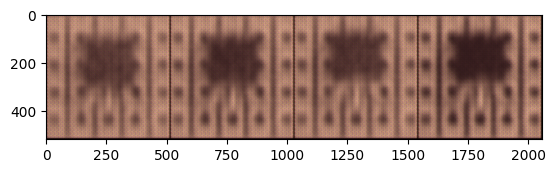


 EPOCH 2/50 	 train loss 0.009210428223013878 	 val loss 0.0081475293263793


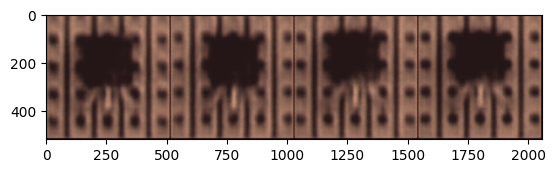


 EPOCH 3/50 	 train loss 0.006456146948039532 	 val loss 0.0067059677094221115


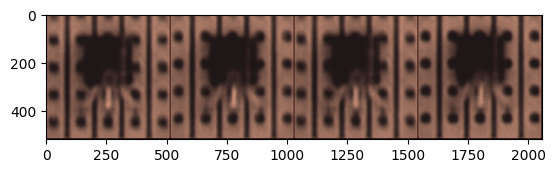


 EPOCH 4/50 	 train loss 0.005820383317768574 	 val loss 0.006724393926560879


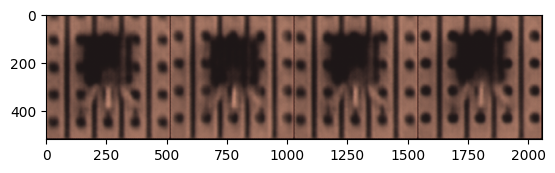


 EPOCH 5/50 	 train loss 0.00534804305061698 	 val loss 0.006045487709343433


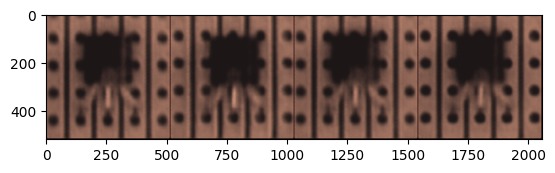


 EPOCH 6/50 	 train loss 0.00501865753903985 	 val loss 0.00593742448836565


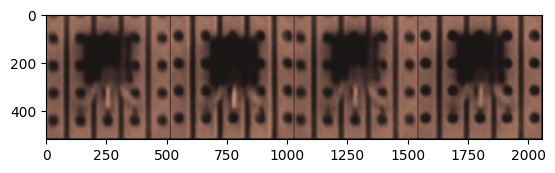


 EPOCH 7/50 	 train loss 0.004867007490247488 	 val loss 0.00562575226649642


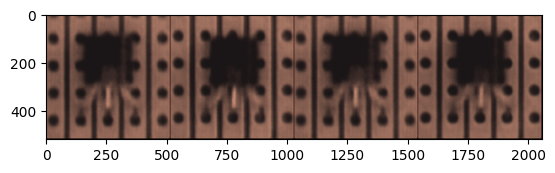


 EPOCH 8/50 	 train loss 0.004909554962068796 	 val loss 0.005892299115657806


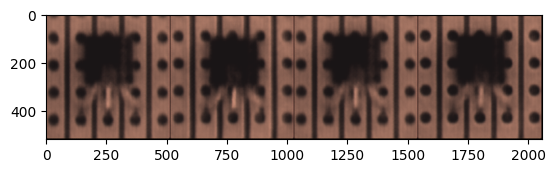


 EPOCH 9/50 	 train loss 0.004774936009198427 	 val loss 0.005794032476842403


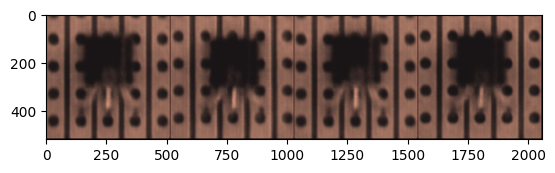


 EPOCH 10/50 	 train loss 0.0046956841833889484 	 val loss 0.00552097475156188


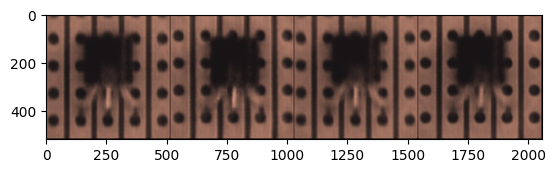


 EPOCH 11/50 	 train loss 0.00448887562379241 	 val loss 0.005203769542276859


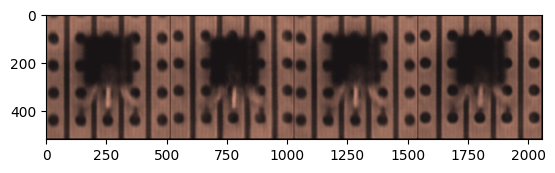


 EPOCH 12/50 	 train loss 0.004348477814346552 	 val loss 0.005746861454099417


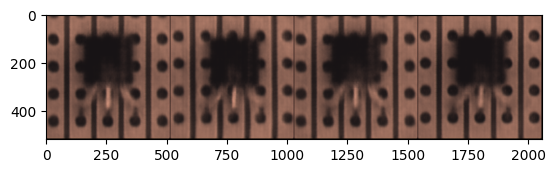


 EPOCH 13/50 	 train loss 0.004314431454986334 	 val loss 0.005556109361350536


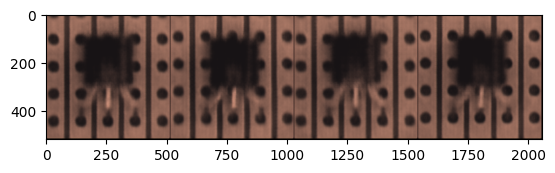


 EPOCH 14/50 	 train loss 0.0044918060302734375 	 val loss 0.00571421068161726


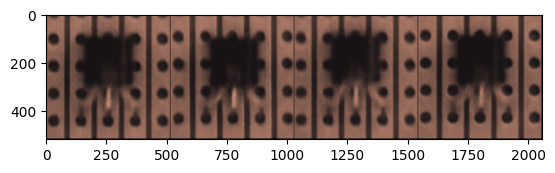


 EPOCH 15/50 	 train loss 0.004394256044179201 	 val loss 0.005384902004152536


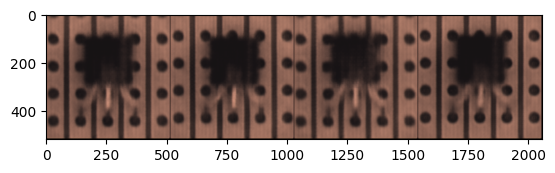


 EPOCH 16/50 	 train loss 0.0042913188226521015 	 val loss 0.0059207468293607235


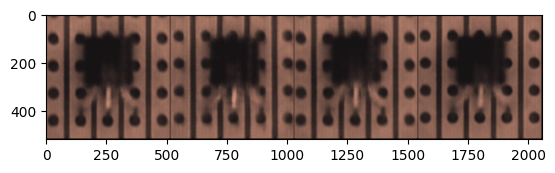


 EPOCH 17/50 	 train loss 0.004273845814168453 	 val loss 0.0053437151946127415


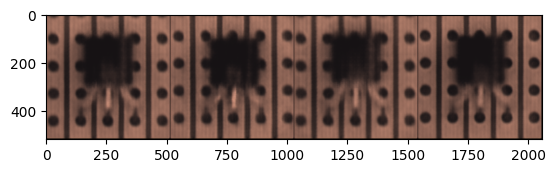


 EPOCH 18/50 	 train loss 0.0041328310035169125 	 val loss 0.005462615750730038


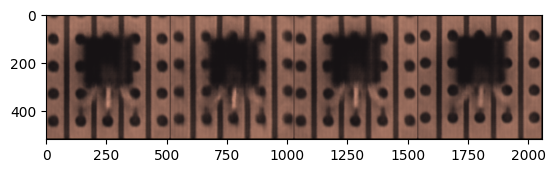


 EPOCH 19/50 	 train loss 0.004097226541489363 	 val loss 0.005636358633637428


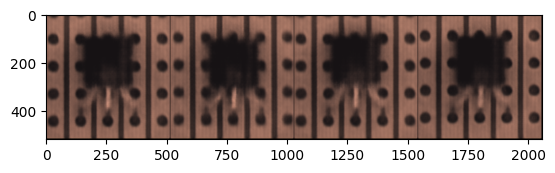


 EPOCH 20/50 	 train loss 0.004183371085673571 	 val loss 0.0053364890627563


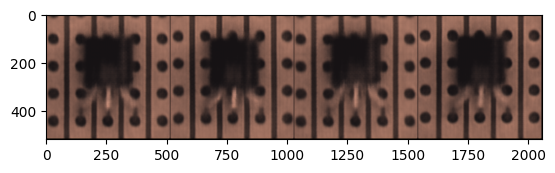


 EPOCH 21/50 	 train loss 0.003983309026807547 	 val loss 0.005923076532781124


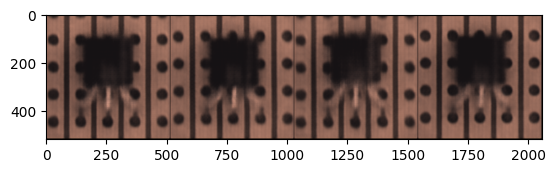


 EPOCH 22/50 	 train loss 0.004125579725950956 	 val loss 0.005668741650879383


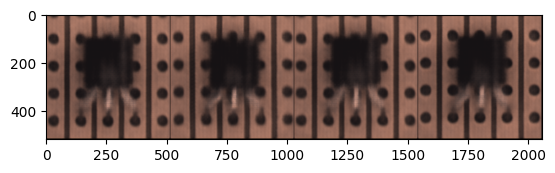


 EPOCH 23/50 	 train loss 0.0043266345746815205 	 val loss 0.005563040263950825


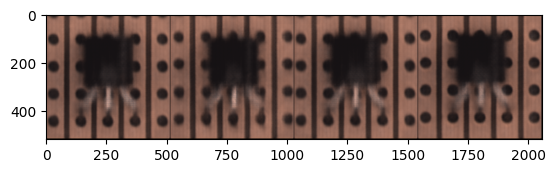


 EPOCH 24/50 	 train loss 0.00414767162874341 	 val loss 0.005922024603933096


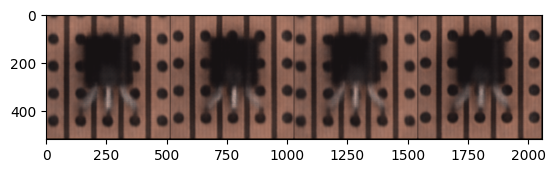


 EPOCH 25/50 	 train loss 0.004131453111767769 	 val loss 0.005702805705368519


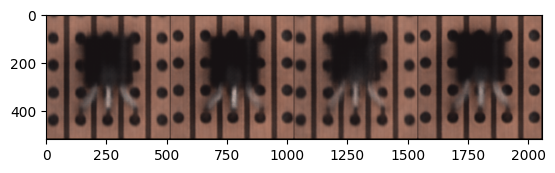


 EPOCH 26/50 	 train loss 0.004190243314951658 	 val loss 0.0057977004908025265


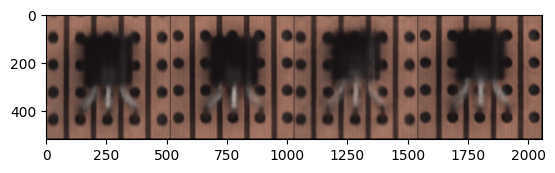


 EPOCH 27/50 	 train loss 0.004052409436553717 	 val loss 0.005483454093337059


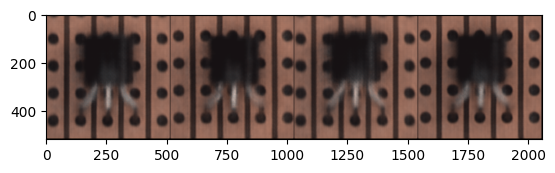


 EPOCH 28/50 	 train loss 0.0038188123144209385 	 val loss 0.005426241084933281


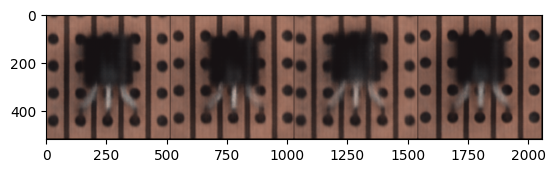


 EPOCH 29/50 	 train loss 0.003617384470999241 	 val loss 0.0052639213390648365


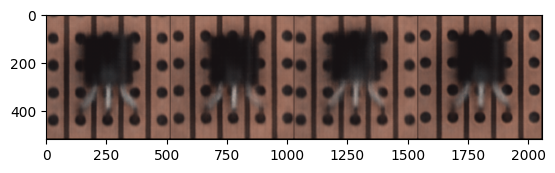


 EPOCH 30/50 	 train loss 0.0035865067038685083 	 val loss 0.005391465499997139


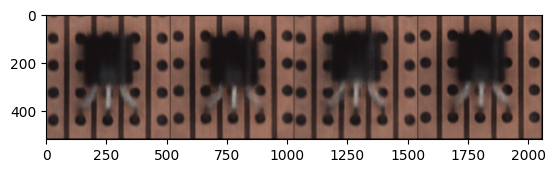


 EPOCH 31/50 	 train loss 0.003841821104288101 	 val loss 0.005631394684314728


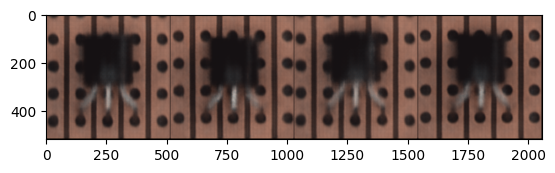


 EPOCH 32/50 	 train loss 0.003933391068130732 	 val loss 0.004927933681756258


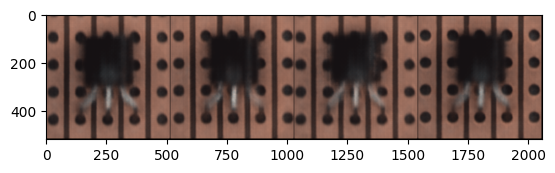


 EPOCH 33/50 	 train loss 0.003931501880288124 	 val loss 0.005287939216941595


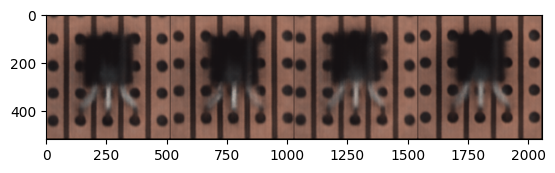


 EPOCH 34/50 	 train loss 0.003628510981798172 	 val loss 0.005023899953812361


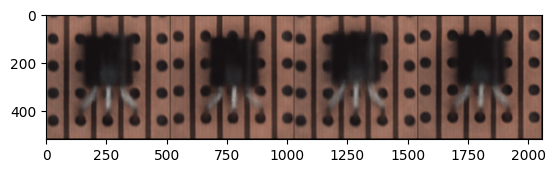

KeyboardInterrupt: 

In [72]:
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss =train_epoch(model,device,train_dataloader,loss,optim,scheduler)
   val_loss = test_epoch(model,device,val_dataloader,loss)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)
   plot_ae_outputs(model,n=10)

Temp Section do not delete

torch.Size([1, 3, 512, 512])
tensor([[[[0.3372, 0.4266, 0.5067,  ..., 0.4588, 0.4784, 0.3134],
          [0.4042, 0.4751, 0.6021,  ..., 0.5286, 0.5167, 0.4084],
          [0.4345, 0.5575, 0.5691,  ..., 0.5802, 0.5626, 0.4829],
          ...,
          [0.5126, 0.5446, 0.4910,  ..., 0.5588, 0.4972, 0.3966],
          [0.4904, 0.5554, 0.5046,  ..., 0.4941, 0.4549, 0.4284],
          [0.3916, 0.4452, 0.4337,  ..., 0.4539, 0.3803, 0.2705]],

         [[0.2525, 0.2548, 0.3606,  ..., 0.3674, 0.3037, 0.2023],
          [0.3857, 0.3660, 0.3354,  ..., 0.4250, 0.3847, 0.3307],
          [0.3487, 0.4226, 0.3932,  ..., 0.4109, 0.3937, 0.3629],
          ...,
          [0.2933, 0.3657, 0.3824,  ..., 0.4089, 0.3407, 0.3310],
          [0.3011, 0.3463, 0.3597,  ..., 0.4077, 0.3114, 0.2631],
          [0.2034, 0.3134, 0.3015,  ..., 0.3168, 0.3121, 0.2111]],

         [[0.1928, 0.2155, 0.2623,  ..., 0.3200, 0.3091, 0.2542],
          [0.2841, 0.2887, 0.3354,  ..., 0.3863, 0.3094, 0.2743],
          [0.

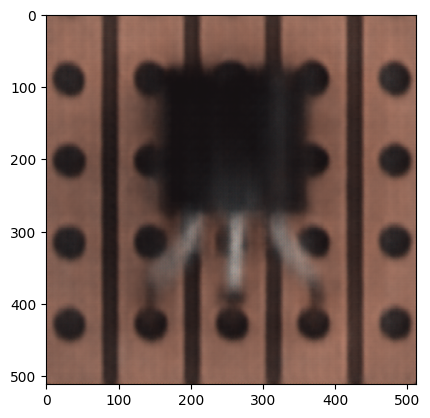

In [73]:
inputs = next(iter(test_dataloader))
inputs = inputs.to(device)
out = model(inputs)
print(out.shape)
out = out.cpu()
print(out)
out = torchvision.utils.make_grid(out)
out =  out.detach()
imshow(out)

Loss Plot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


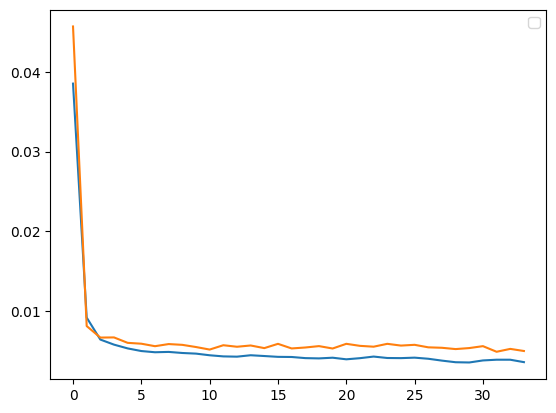

In [74]:
plt.plot(diz_loss['train_loss'])
plt.plot(diz_loss['val_loss'])
plt.legend()
plt.show()

Latent Representation

In [75]:
train = []
val = []
test = []
data = []
with torch.no_grad():
        for image_batch in train_dataloader:
            image_batch = image_batch.to(device)
            decoded_data = model.encode(image_batch)
            train.append(decoded_data.cpu())
            data.append(decoded_data.cpu())
        for image_batch in val_dataloader:
            image_batch = image_batch.to(device)
            decoded_data = model.encode(image_batch)
            val.append(decoded_data.cpu())
            data.append(decoded_data.cpu())
        for image_batch in test_dataloader:
            image_batch = image_batch.to(device)
            decoded_data = model.encode(image_batch)
            test.append(decoded_data.cpu())
            data.append(decoded_data.cpu())
        train = torch.cat(train)
        val = torch.cat(val)
        test = torch.cat(test)
        data = torch.cat(data)
torch.set_printoptions(threshold=10_000)

/var/folders/zq/n748bt1s4fdbgrfv7nj7s2n80000gn/T/ipykernel_2420/472349920.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(train[:, 0], train[:, 1], train[:, 2],cmap='hot')
/var/folders/zq/n748bt1s4fdbgrfv7nj7s2n80000gn/T/ipykernel_2420/472349920.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(val[:, 0], val[:, 1], val[:, 2],c='#FFA500', cmap='hot')
/var/folders/zq/n748bt1s4fdbgrfv7nj7s2n80000gn/T/ipykernel_2420/472349920.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(test[:, 0], test[:, 1], test[:, 2],c='#00FF00', cmap='hot')


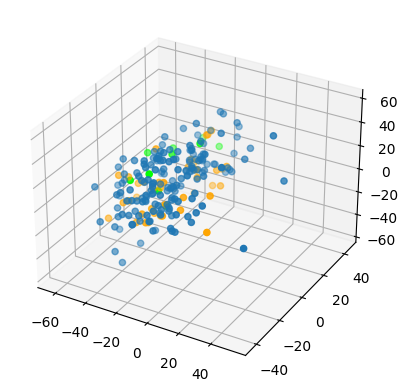

In [76]:

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(train[:, 0], train[:, 1], train[:, 2],cmap='hot')
ax.scatter(val[:, 0], val[:, 1], val[:, 2],c='#FFA500', cmap='hot')
ax.scatter(test[:, 0], test[:, 1], test[:, 2],c='#00FF00', cmap='hot')

# Display the plot
plt.show()

[1 0 2 0 2 1 0 2 0 1 2 0 1 1 0 0 0 0 0 1 2 0 0 0 1 2 0 2 0 0 1 0 1 2 1 2 2
 1 2 2 0 1 1 0 2 0 1 0 2 0 0 0 2 0 0 0 1 2 0 2 0 0 0 1 1 1 0 0 2 2 0 2 1 0
 0 0 0 0 0 0 1 1 1 0 2 0 2 0 2 1 0 0 2 0 2 0 2 1 2 2 2 2 2 2 0 0 0 0 2 1 2
 2 2 0 1 0 0 0 0 2 0 1 0 1 0 1 0 2 2 0 0 0 2 2 2 0 2 0 1 0 0 0 1 0 2 1 2 1
 2 1 1 1 0 2 0 1 1 1 0 1 0 1 1 1 1 0 0 2 0 1 0 1 1 2 2 2 1 1 0 1 2 0 1 0 0
 2 2 0 1 2 0 1 2 1 0 0 1 0 2 0 0 2 1 0 1 2 2 1 2 0 1 1 2 0 0 1 0 1 0 0 1 1
 1]
[[ -7.30720004 -21.52764704  21.41977132]
 [-16.8099767   17.96843621  11.23448619]
 [-35.87548736  -7.11938486 -12.23577786]]


/Users/nayansavaliya/Desktop/AnomalyDetection/ad-venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


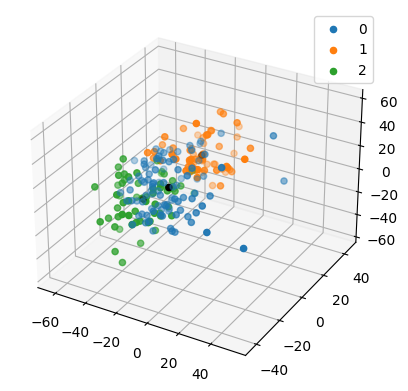

In [78]:
from sklearn import cluster
kmeans = cluster.KMeans(init='k-means++',n_clusters=3).fit(data)

labels = kmeans.labels_
print(labels)
centroids = kmeans.cluster_centers_
print(centroids)
u_labels = np.unique(labels)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in u_labels:
    ax.scatter(data[labels == i , 0] , data[labels == i , 1], data[labels == i , 2] , label = i)

ax.scatter(centroids[:,0] , centroids[:,1] , centroids[:,2], color = 'k')
plt.legend()
plt.show()



In [90]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=3, random_state=0).fit(data)
print(gm.means_)
print(gm.predict(test))

[[-16.39317994  15.41775534   9.940798  ]
 [ -5.3295204  -28.89488264  18.98826266]
 [-28.29880969 -12.71020624   1.51589258]]
[2 1 0 1 2 1 0 0 0 0]


Encoder-Decoder Output Loss Histogram

In [97]:
model.eval()
ms = []
kl_loss = nn.KLDivLoss(reduction = 'batchmean')
for image_batch in train_dataloader:
    image_batch = image_batch.to(device)
    decoded_data = model(image_batch)
    mse = kl_loss(decoded_data, image_batch).detach()
    ms.append(mse.cpu().detach().item())


print(ms)
hist, bins = np.histogram(ms, density=False)
print(hist)
print(bins)
#plt.hist(hist,bins = bins, density=False)
#ax.hist(fraud, bins=50, density=True, label="fraud", alpha=.6, color="red")

plt.show()

[-336048.875, -333965.71875, -332663.375, -336446.21875, -338596.5, -335908.6875, -333099.25, -331845.4375, -336173.8125, -332721.375, -336001.1875, -333687.90625, -337485.5625, -333236.6875, -335166.59375, -337842.1875, -333523.5625, -337214.0, -330898.625, -335827.3125, -333093.9375, -334455.9375, -334230.28125, -335135.75, -333570.4375, -334988.28125, -334656.9375, -332762.1875, -335933.25, -333926.40625, -335552.4375, -336449.375, -334990.125, -333590.1875, -330410.1875, -334870.9375, -331129.375, -334663.625, -334660.90625, -338043.09375, -336442.0, -333780.75, -330574.9375]
[3 2 4 6 8 6 6 3 1 4]
[-338596.5     -337777.86875 -336959.2375  -336140.60625 -335321.975
 -334503.34375 -333684.7125  -332866.08125 -332047.45    -331228.81875
 -330410.1875 ]
